### Voice Recognition Model

Hi all! When I first entered machine learning there were a few use cases that I thought were absolutely amazing. I had a strong background in statistics (a bachelors in physics can do that to you), but many of the models I saw in the field seemed more like black magic than processes generated from mathematical principles. 

So I did what any good scientist might do, I set out to build simple proofs of concepts. I made chat bots, reinforcement learners, computer vision models. I tried methodologies that were decades old and ones that were brand new. I'm still amazed at how much of what I learned messing around with these toy model came back to help me in actual production model builds later in my career. 

To this end, I wanted to publish some of the more fun projects that I toyed around with. I've tried to clean up some of these older projects (I'm not the best coder now but I was much worse back when I wrote these) so please forgive any residual sloppiness.

So, what are we learning about today? Voice recognition! While audio recordings are jsut signals and signal processing/modeling is a very well covered discipline, I've found that a lot of new data scientists struggle to work with sound. However, there are some super cool things that you can do with sound. For example, I've been working with auscultatory (sound) recordings taken of the chest to try to diagnose heart pathologies. You could also create models to try and triangulate exact location of a gun shot in a city based on recordings from multiple speakers placed in the vicinity of the gunshot. 

Today we'll do something far less exciting: voice recognition. We won't be exploring the state of the art in voice recognition (which is based in deep learning, is pretty complicated, and requires more data and computing power than you or I probably want to bother with). Instead, I'll show you a simple modeling approach that works decently using Gaussian mixture models.  

To get to the final model we'll need to cover a lot of pre-processing material. Here's our outline:
* Preprocessing
    * Pre-emphasis
    * Removing Silence
    * Normalize Energy Density
    * Framing
    * Windowing
    * Fourier-Transform and Power Spectrum
    * Filter Banks
    * Mel-frequency Cepstral Coefficients (MFCCs)
    * Mean Normalization
    * Filter Banks vs MFCCs
* Modeling the Human Voice

If you are new to signal processing and/or time series analysis, I would recommend reading through the first sections of my time series course before delving into this tutorial. I assume familiarity with concepts like Fourier transforms, stationarity, and basis functions/frequencies.

### Preprocessing

We'll start by learning how to augment our audio signals in such a way that we can extract as many interesting and salient features as possible. As you can see below, the raw audio signal is just a one dimensional vector. We'll work to augment the same such that we learn about the frequencies that comprise the signal and the power distribution of those frequencies. These are the features that really make our voices unique.

I will largely draw from this blog for pre-processing with a few changes and exceptions: [Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

In [1]:
import numpy as np
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

from sklearn import mixture
from sklearn.externals import joblib
import glob

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import librosa

import IPython.display as ipd
import librosa.display

import scipy.stats as st

Audio Signal Vector: 
[-1.2653547e-06  1.4176046e-06 -1.1516612e-06 ... -1.8368870e-03
 -2.2029171e-03 -2.1080920e-03]


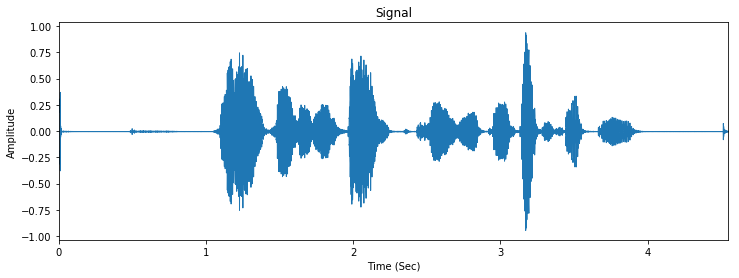

In [3]:
# I really like librosa for audio processing in python
# as well as to just display samples
# however, librosa handles much of the nitty gitty for us
# so I'll switch to scipy to teach the preprocessing concepts
# and then back to librosa when we get to the actual model build
# it's good to get a taste of the nitty gritty to make sure
# you know how the sausage is made!

x, sr = librosa.load("James_train.wav")

print("Audio Signal Vector: \n{}".format(x))

plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

ipd.Audio(x, rate=sr)

We'll start with a few basic transforms in the [time domain](https://en.wikipedia.org/wiki/Time_domain). Eventually we'll want to start working with our signal in the [frequency domain](https://en.wikipedia.org/wiki/Frequency_domain) which has much more rich features for our model to work with. The frequencies of our voices can tell us a lot such as gender, age, etc. 

Our first transform is a pre-emphasis filter that amplifies higher frequencies in our signal. We usually do this for a few different reasons:
* High frequencies often have lower power magnitudes than lower frequencies and our amplification can add some balance to the signal. This can also helps prevent loss of information in the higher frequency spectrum in later transformations.
* This can help avoid numerical issues with Fourier transforms.
* Can act to improve signal-to-noise ratio.

Honestly, we often [skip the pre-emphasis filter](https://www.quora.com/Why-is-pre-emphasis-i-e-passing-the-speech-signal-through-a-first-order-high-pass-filter-required-in-speech-processing-and-how-does-it-work/answer/Nickolay-Shmyrev?srid=e4nz&share=71ca3e28) these days as signal processing methods have improved drastically as more computing power has become available to modelers. The benefits of pre-emphasis filters become negligible when one applies transforms like mean normalization (which I address later).

However, it's a nice method to know about in case you want a quick transform and choose not to use mean normalization later in the preprocessing pipeline.

The formula for our filter is as follows:

$y(t) = x(t) - \alpha x(t-1)$

I show before and after plots of our signal below.

In [4]:
sample_rate, signal = scipy.io.wavfile.read('James_train.wav')
i = 5.5
signal = signal[0:int(i * sample_rate)]  # Keep the first i seconds

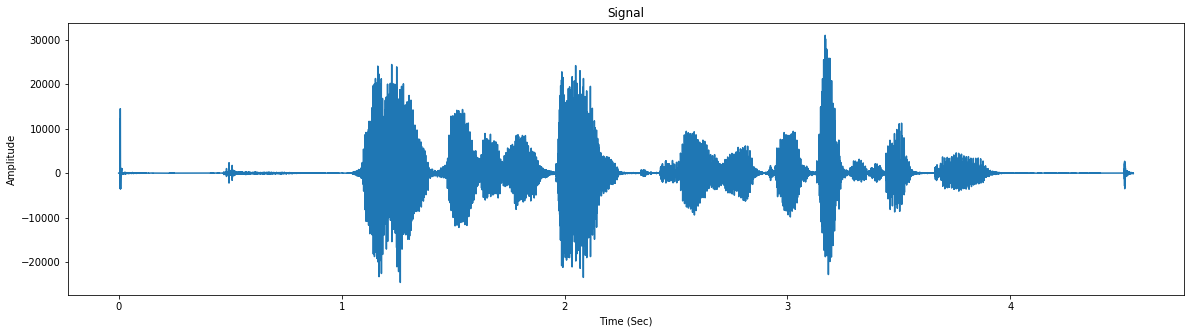

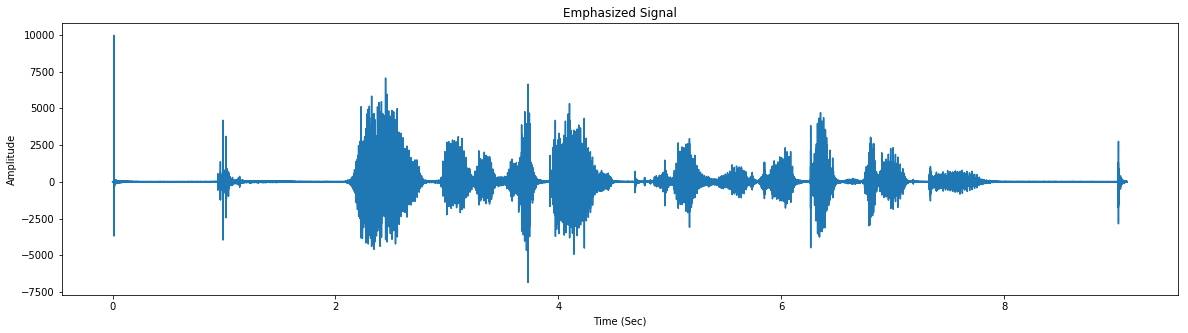

In [5]:
Time=np.linspace(0, len(signal)/sample_rate, num=len(signal))

plt.figure(figsize=(20,5))
plt.plot(Time,signal[:,0])
plt.title('Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

Okay, next we want to discard the useless parts of our sample. Namely, we'll remove the silent parts. Dealing with silence is difficult. We could use the silence to try to model certain speech patterns (maybe the speaker hesitates or stutters more than most people), but often enough the amount and length of silence in our speech depends highly on context. We want our model to identify a voice independent of the context in which the voice sample was taken (i.e. shouting, whispering, fast, slow). 

Removing silence can be tricky! Below I implement a simple thresh holding filter that removes any vector value below a threshold. Librosa also has a function to do this which I sue to compare to my filter.

I will note, some modelers prefer to skip the removing silence and energy normalization steps. I won't weigh in on this debate, but I encourage to try building models with and without these steps and choose a method for yourself.

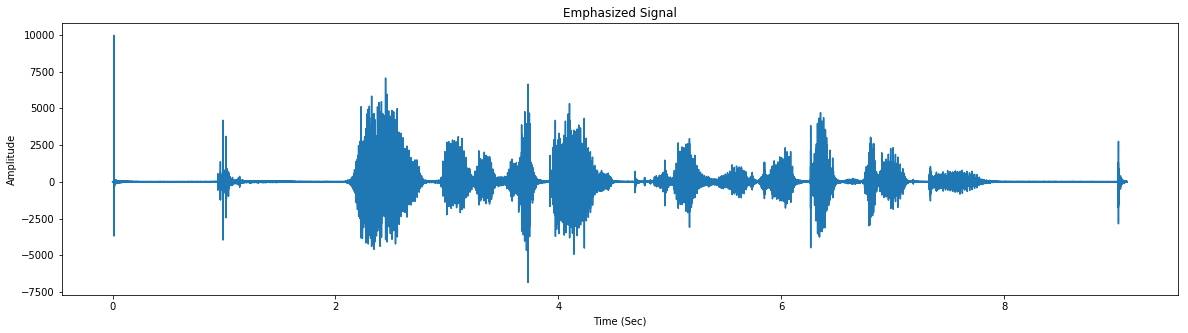

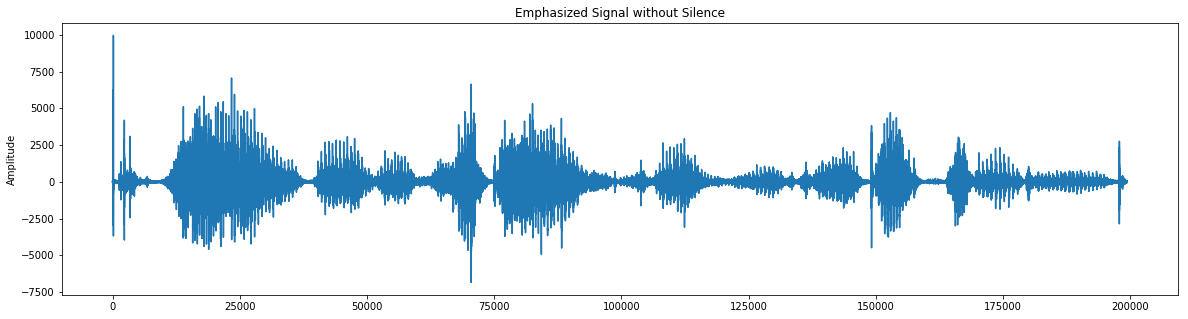

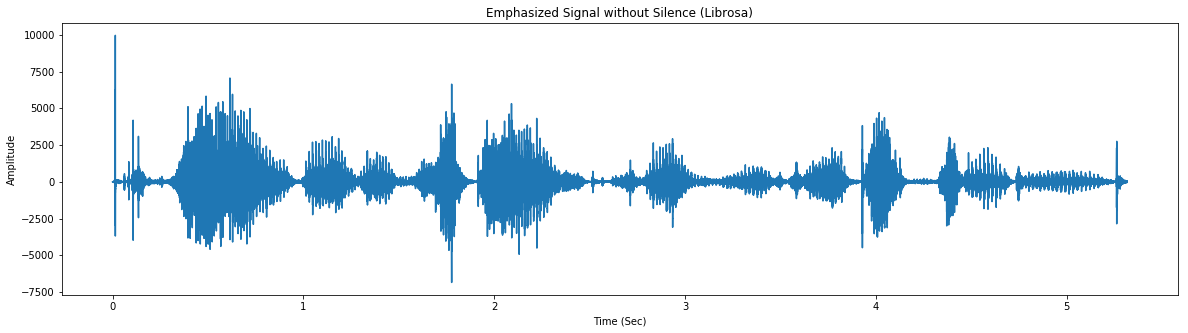

In [6]:
plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

s = emphasized_signal[ numpy.absolute(emphasized_signal) > 30]

plt.figure(figsize=(20,5))
plt.plot(s)
plt.title('Emphasized Signal without Silence')
plt.ylabel('Amplitude')
plt.show()

# remove silence
y = librosa.effects.split(emphasized_signal,top_db=30)
l = []
for i in y:
    l.append( emphasized_signal[i[0]:i[1]] )
emphasized_signal = np.concatenate(l,axis=0)

Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal without Silence (Librosa)')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

Try listening to both filtered examples (mine and librosa's) below. You'll notice that librosa does a MUCH better job of filtering silence. We'll go with librosa's filter, but at least you have an idea of how you could roll your own if you wanted to.

In [7]:
print("My Augmentation")
ipd.Audio(s, rate=2*sample_rate)

My Augmentation


In [8]:
print("Librosa Augmentation")
ipd.Audio(emphasized_signal, rate=2*sample_rate)

Librosa Augmentation


After removing silence, it is often common to normalize the signal by the energy density of the signal. We do this to try to remove the effects of speaking louder or faster. We want to recognize a person no matter how fast or loudly they may be speaking.

I get pretty good results with and without normalizing by energy density. I will let the reader experiment as he or she sees fit. I personally try to avoid using preprocessing methods just because they are common practice. If it makes sense and improves your model: use it. Otherwise, why add complexity? Anyway, for the purposes of this blog post I'll use the normalized signal.

Looking at the normalized signal, it is pretty obvious that it is in fact accounting for my cadence and speed of speech (as intended).

In [11]:
# normalize for energy density
VTH_Multiplier = 0.05
VTH_range=100
energy = [ a**2 for a in emphasized_signal]
Voiced_Threshold = VTH_Multiplier*np.mean(energy)
clean_samples=[0]

for sample_set in range(0,len(emphasized_signal)-VTH_range,VTH_range):
    sample_set_th = np.mean(energy[sample_set:sample_set+VTH_range])
    if sample_set_th>Voiced_Threshold:
        clean_samples.extend(emphasized_signal[sample_set:sample_set+VTH_range])

s = np.array(clean_samples)

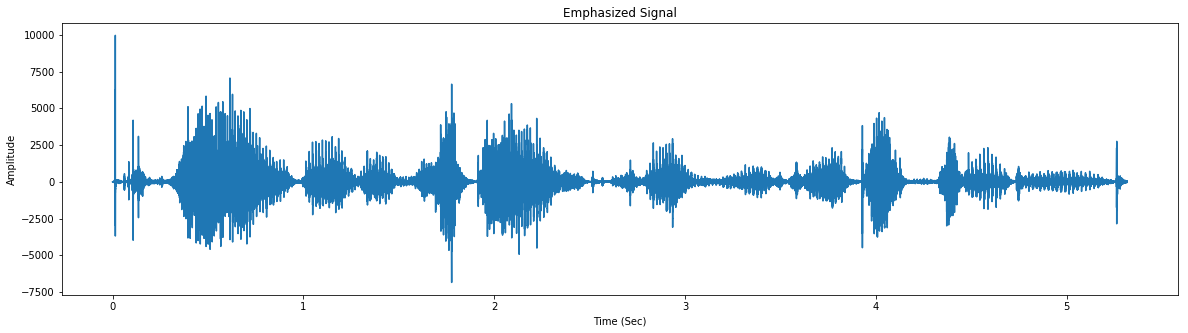

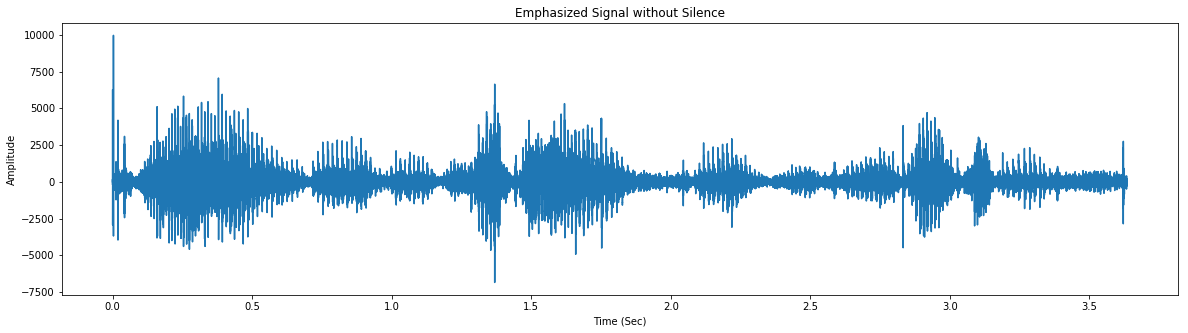

In [12]:
Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

Time=np.linspace(0, len(s)/sample_rate, num=len(s))

plt.figure(figsize=(20,5))
plt.plot(Time,s)
plt.title('Emphasized Signal without Silence')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

In [13]:
print("Unnormalized")
ipd.Audio(emphasized_signal, rate=2*sample_rate)

Unnormalized


In [14]:
print("Normalized")
ipd.Audio(s, rate=2*sample_rate)

Normalized


In [15]:
# use normalized signal
emphasized_signal = s

Now that we have removed silence and normalized by energy density in our signal, we can move on to framing! Framing is the process of splitting the signal into windows/frames. We have a pretty complex signal that we are trying to analyze and the frequencies of the signal change a lot over time. To account for this, we look at the frequencies of our signal at different frames/windows across the signal. This preserves the frequency contours across the signal through time. 

Of course this forces us to make the assumption that frequencies in a signal are [stationary](https://en.wikipedia.org/wiki/Stationary_process) over a short time frame. Under this assumption, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

We usually choose frame sizes of 20ms-40ms for speech processing with 50% +/- 10% overlap between adjacent (consecutive) frames. We will also borrow from convention and use frame sizes of 25ms and 10ms for stride size (creating 15ms overlap).

In [16]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

Having sliced our signal into frames, we want to apply a [window function](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows) such as a hamming window to each frame. For the hamming window we can use the following formula:

$w[n] = 0.54 − 0.46 cos ( \frac{2πn}{N − 1} )$

where $0 \leq n \leq N - 1$, $N$ is the window length. I plot the hamming window below. We apply this window function mostly to counteract the FFT assumption that the data is infinite (which it is not) and to reduce [spectral leakage](https://en.wikipedia.org/wiki/Spectral_leakage).

The hamming window has been the historical standard for speech processing. It provides a decent balance between frequency resolution (e.g. the separability of closely grouped peaks in the frequency domain) and dynamic range (e.g. the size of the main lobe compared to side lobes) and so works well for speech processing applications. The square-root hann window is also common for signal reconstruction applications as it is more forgiving when applying aggressive frequency domain processing.

I find that a lot of students have trouble with window functions, so I've plotted a single frame before and after the hamming window is applied. What parts of the signal are preserved? What parts of the signal does the window de-emphasize? Does the effect of this window explain why we created overlapping frames? (hint: look at the middle and ends of the signal before and after the window is applied)

If you have trouble answering these questions you might want to go back and review basic signal processing and window functions (something I was very rusty on before coding up this project!).

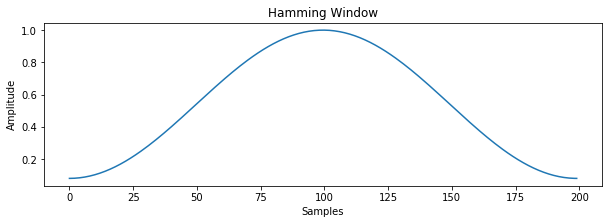

In [17]:
x = numpy.hamming(200)

plt.figure(figsize=(10,3))
plt.plot(x)
plt.title('Hamming Window')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

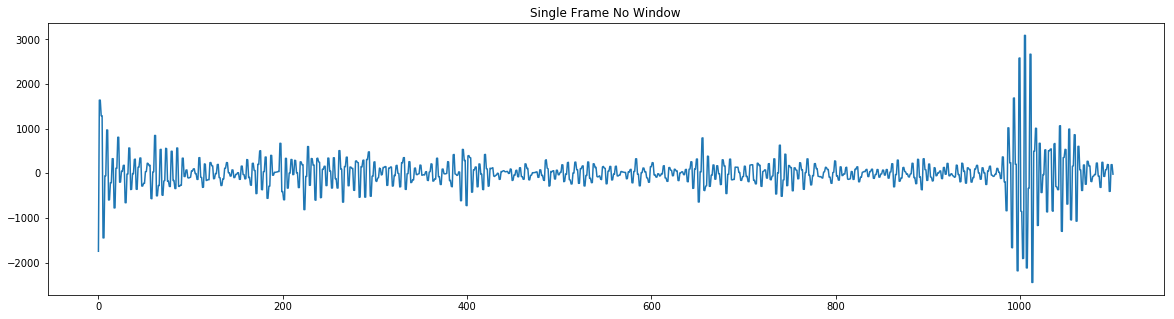

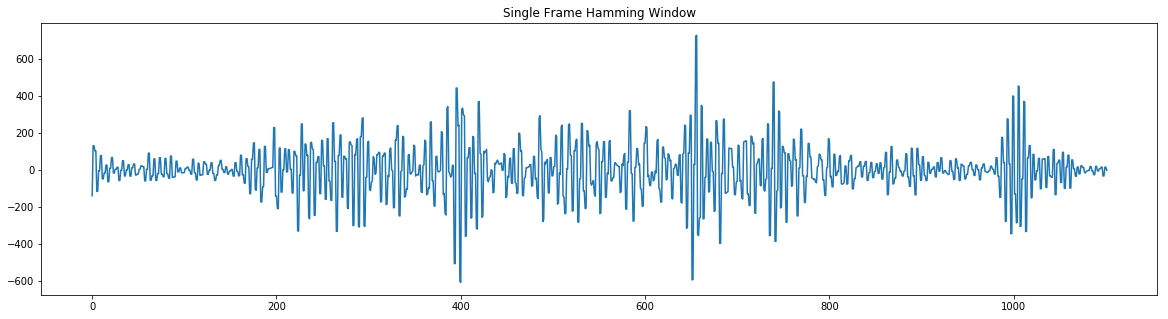

In [18]:
f = frames * numpy.hamming(frame_length)
# frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

x = frames[2]
plt.figure(figsize=(20,5))
plt.plot(x)
plt.title("Single Frame No Window")
plt.show()

x = f[2]
plt.figure(figsize=(20,5))
plt.plot(x)
plt.title("Single Frame Hamming Window")
plt.show()

frames = f

We now perform an N-point FFT ([Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) on each frame to calculate the frequency spectrum. Using the FFT on sliding frames is often called Shirt-Time Fourier Transform ([STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)). We typically set N to 256-512. We then compute the power spectrum ([periodogram](https://en.wikipedia.org/wiki/Periodogram)) using the equation:

$P = \frac{|FFT(x_i)|^2}{N}$

where $x_i$ is the $i^{th}$ frame of the signal x. 

Below I first plot a single frame in the frequency spectrum so that you can get a feel for the FFT as applied to one part of the entire signal.

I then plot the STFT across frames and the signal in the time domain. Try comparing the STFT and the time domain plots (remembering that the x axis are in different units: frames vs seconds). Do the magnitude spikes in the STFT match with large amplitude regions of the time domain plot? Does that make sense?

Lastly I plot the power spectrum of the signal. How do the STFT and power spectrum plots differ? What salient features appear in both the STFT and power spectrum plot?

In [19]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT

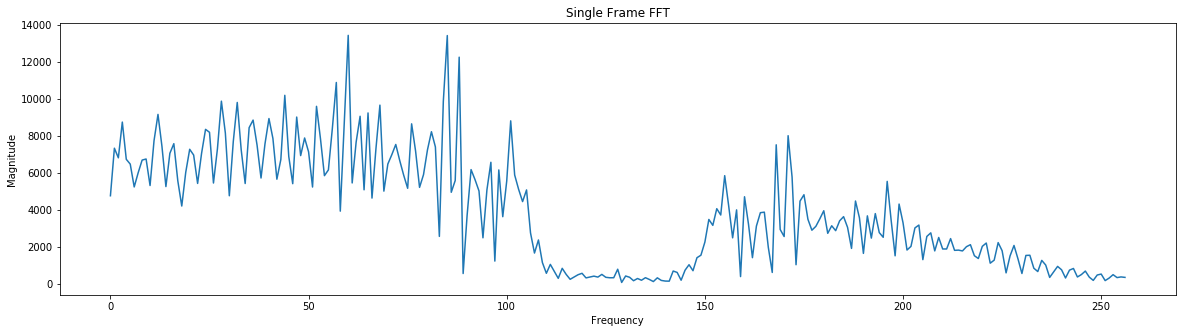

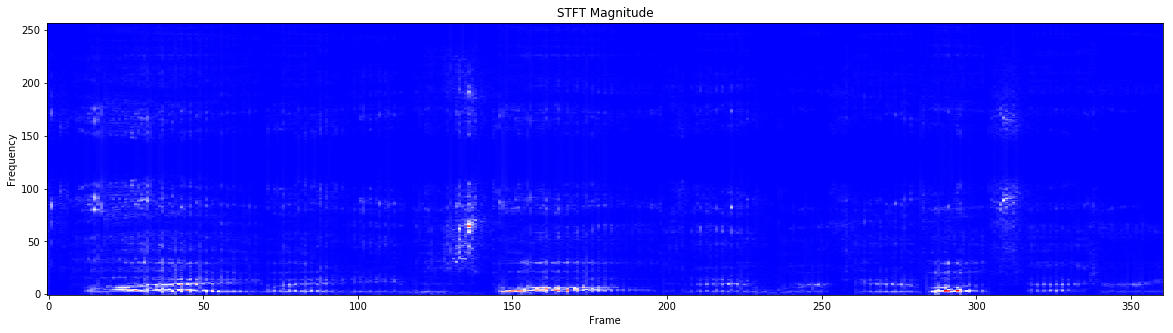

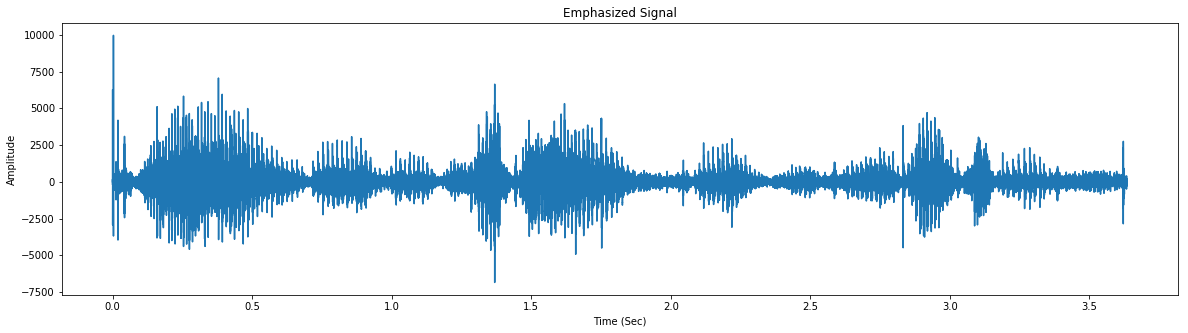

In [20]:
plt.figure(figsize=(20,5))
plt.plot(mag_frames[0])
plt.title("Single Frame FFT")
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(mag_frames.T, interpolation='nearest', cmap=cm.bwr, origin='lower', aspect='auto')
plt.title("STFT Magnitude")
plt.xlabel('Frame')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

In [21]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

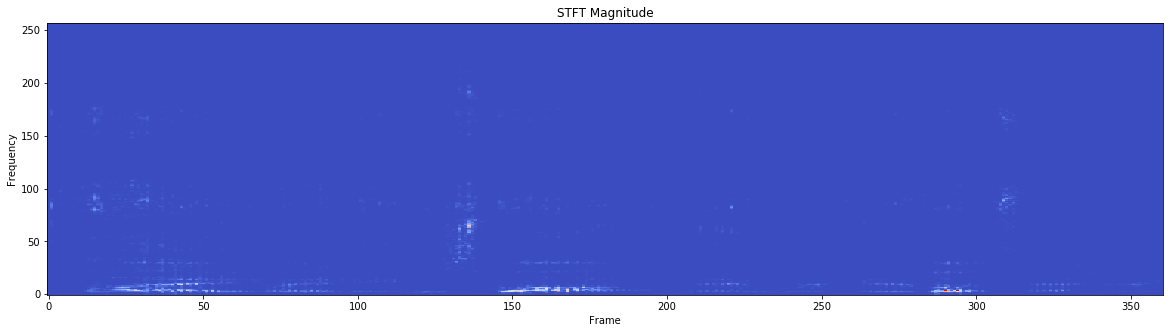

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(pow_frames.T, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
plt.title("STFT Magnitude")
plt.xlabel('Frame')
plt.ylabel('Frequency')
plt.show()

The last filter we will use is by far the most interesting. We will apply a triangular filter (typically 40) on a Mel-scale to the power spectrum in order to extract the frequency bands. The Mel-Scale tries to imitate the non-linear way that the human ear perceives sound. The human ear tends to be more discriminative at lower frequencies and less discriminative at higher frequencies. We convert between Hertz($f$) and Mel ($m$) as follows:

$m = 2595 \log_{10} (1 + \frac{f}{700})$

$f = 700 (10^{m/2595} - 1)$

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown below:

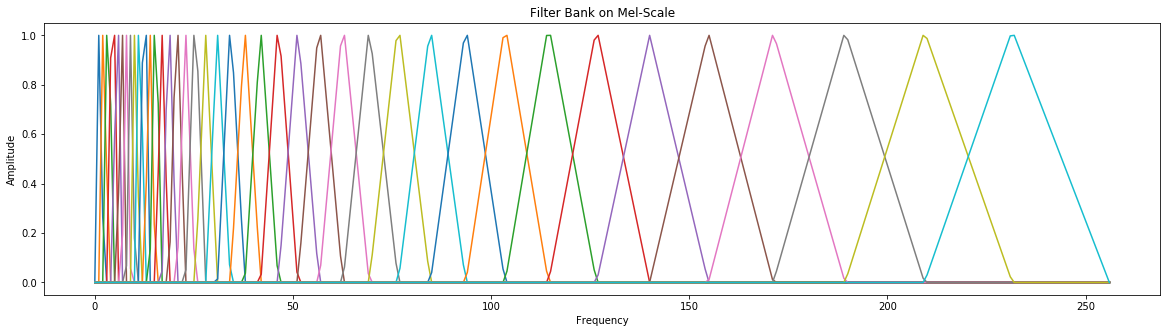

In [23]:
sr = sample_rate
n_fft = 512
n = 40
mels = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n,fmin=0, fmax=sr / 2)
mels /= np.max(mels, axis=-1)[:, None]

plt.figure(figsize=(20,5))
plt.plot(mels.T)
plt.title("Filter Bank on Mel-Scale")
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
plt.show()

We can model this using the following equation ([source](http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)):

$$
H_m(k) =
  \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m - 1) \\
  \end{cases}
$$

In [24]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

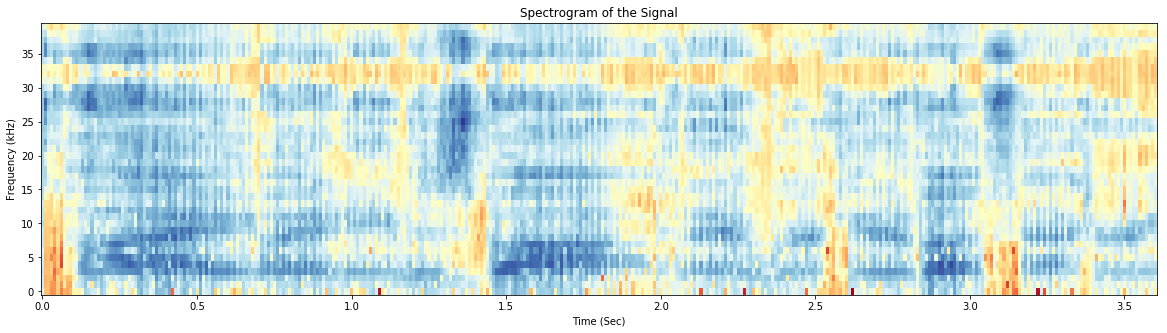

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(filter_banks.T, interpolation='nearest', cmap=cm.RdYlBu, origin='lower', aspect='auto')
plt.title("Spectrogram of the Signal")
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (kHz)')
a = np.array( ax.get_xticks().tolist() )
a = a / 100.0
ax.set_xticklabels(a)
plt.show()

Now we can often just stop here, but the filter bank coefficients computed above are highly correlated (this is a problem for many ML models). We can apply a Discrete Cosine Transform ([DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform)) to de-correlate the filter bank coefficients and provide a compressed representation of the filter banks. 

For ASR ([Automatic Speech Recognition](https://en.wikipedia.org/wiki/Speech_recognition#End-to-end_automatic_speech_recognition)) the cepstral coefficients 2-13 are retained. The discarded coefficients are thought to contribute to fast changes in the filter bank which are not useful as speech features. Now we have our Mel-frequency Cepstral Coefficients (MFCCs)!

Some practioners apply sinusoidal liftering (filtering in the cepstral domain) to the MFCCs to de-emphasize higher MFCCs which some claim improves speech recognition in noisy signals.

cep_lifter is a parameter typically set to 22 in most implementations. However, it refers to the dimensionality of the MFCC vector in the original formulation.

I plot the MFCCs and the signal in the time domain below for comparison.

In [26]:
num_ceps = 12
cep_lifter = 22
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

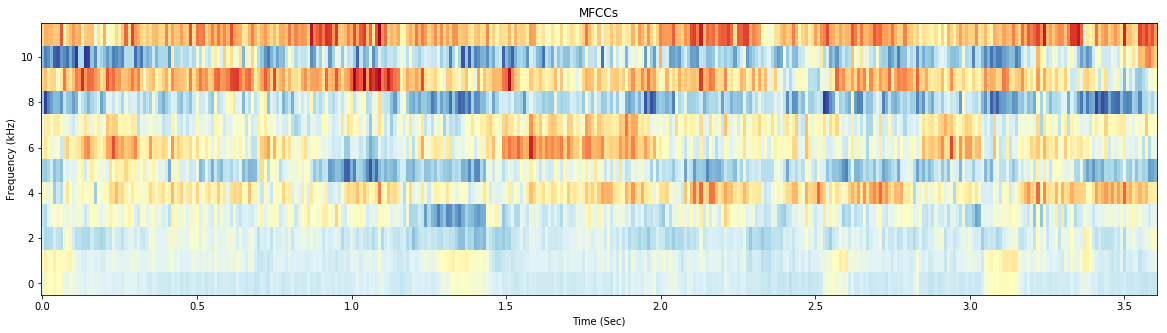

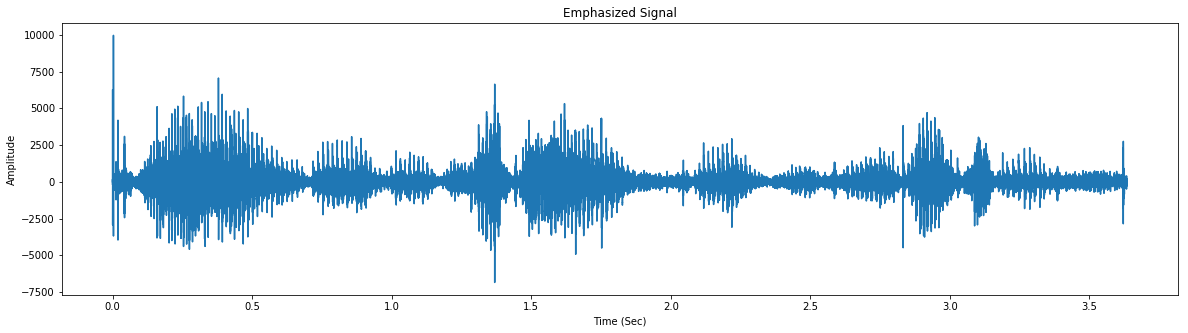

In [27]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(mfcc.T, interpolation='nearest', cmap=cm.RdYlBu, origin='lower', aspect='auto')
plt.title("MFCCs")
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (kHz)')
a = np.array( ax.get_xticks().tolist() )
a = a / 100.0
ax.set_xticklabels(a)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

Finally, we can implement mean normalization. As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.

In [28]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

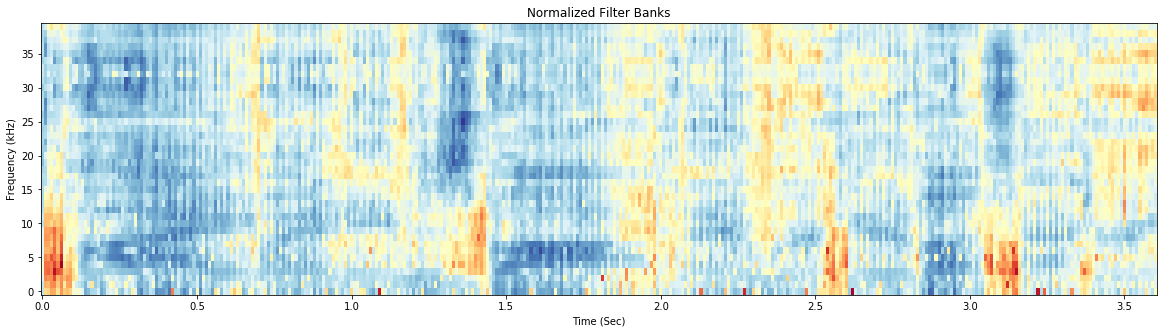

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(filter_banks.T, interpolation='nearest', cmap=cm.RdYlBu, origin='lower', aspect='auto')
plt.title("Normalized Filter Banks")
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (kHz)')
a = np.array( ax.get_xticks().tolist() )
a = a / 100.0
ax.set_xticklabels(a)
plt.show()

In [30]:
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

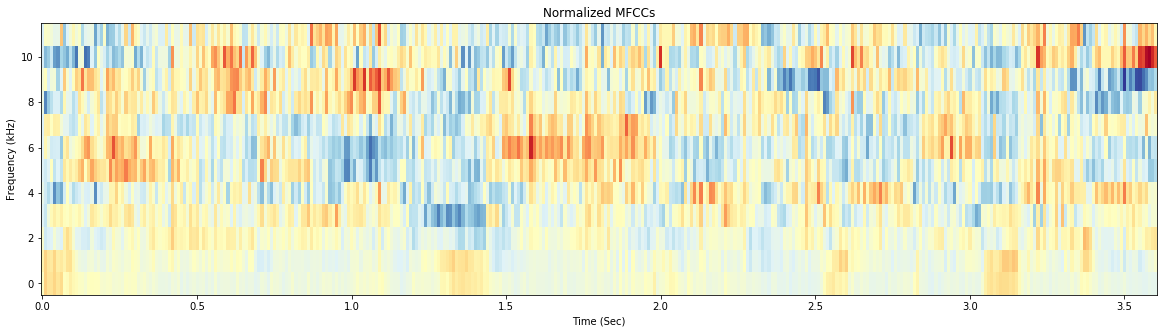

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(mfcc.T, interpolation='nearest', cmap=cm.RdYlBu, origin='lower', aspect='auto')
plt.title("Normalized MFCCs")
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (kHz)')
a = np.array( ax.get_xticks().tolist() )
a = a / 100.0
ax.set_xticklabels(a)
plt.show()

MFCCs are very popular for automatic speech recognition (ASR) using [GMMs](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) and [HMMs](https://en.wikipedia.org/wiki/Hidden_Markov_model). Since Deep Learning has become the state of the art it has been called into question if MFCCs are still needed. One might do away with the DCT step altogether and just input the entire spectrogram into your neural net. I have often seen, for example, MFCCs input into [CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network) for audio classification tasks, but as often as not the MFCC is used instead of the entire spectrogram to limit the required size of the neural net or by some historical convention rather than any principled reason. It is beneficial to note that Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

It is sensible to question if the Fourier Transform is a necessary operation. Given that the Fourier Transform itself is also a linear operation, it might be beneficial to ignore it and attempt to learn directly from the signal in the time domain, using an [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network) or [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) for example. However, the Fourier transform operation is a difficult operation to learn and may arguably increase the amount of data and model complexity needed to achieve the same performance. Moreover, in doing Short-Time Fourier Transform (STFT), we’ve assumed the signal to be stationary within this short time and therefore the linearity of the Fourier transform would not pose a critical problem.

### The Model

In case you forgot...we're hear to build a model. I spent a lot of time talking about how we prepare the data, but I haven’t really mentioned out model yet. We'll be using a GMM (you'll not from my previous work how much I like GMMs for proof of concept work). GMMs and HMMs were both state of the art for ASR a long time ago, but have been replaced by various deep learning methods. However, they are excellent models to use if you don't have millions of audio samples, some heavy duty hardware, or expertise with deep learning models. In fact, we need almost no data to create a passable POC (proof of concept).

First we need to process our samples. I've bundled all of the steps above into a simple function. I let librosa do most of the heavy lifting this time (no need to reinvent the wheel now that we understand how the preprocessing steps work). I also calculate a few features that we didn't talk about before. Namely, I use delta MFCC. This is the change in the MFCC over time. Using the MFCC, Delta MFCC, Energy, and Delta Energy of the audio signal is very popular in ASR. We could really go down a rabbit hole here, but suffice it to say that Delta MFCC gives us more information about the frequency contours of our sample that can be important. Having more nuanced speech features is really important if we expect to run a large number of voices through our model since the probability that we'll see two humans with a similar voice gets higher the more human subjects we sample to test our model on. 

I've created a bunch of audio samples to use. Feel free to make your own samples or find an open source speech audio library. It's very hard to make our model robust to recordings from different kinds of microphone. In other words, without knowing what makes and model of microphone all of our recordings came from, it's hard to prevent the model from merely making predictions based on what kind of microphone was used to record the samples. To counter this I sued the exact same microphone to take all of my recordings. More compelx sample treatment and modeling approaches can handle this microphone problem. 

I've taken sampels from male and female subjects. Each subject game 3 recordings:
* Random Sentence ~5sec long
* "Music expresses that which cannot be put into words and that which cannot remain silent."
* "Place the bottom crust in your pan. Fill with apples, mounded slightly. Cover with a lattice work crust."

I trained on my own voice using the phrase:
* "Hi my name is Bob and I work at a button factory"

In [34]:
def create_sample(path):
    x, sr = librosa.load(path)
    
    # remove silence
    y = librosa.effects.split(x,top_db=30)
    l = []
    for i in y:
        l.append( x[i[0]:i[1]] )
    x = np.concatenate(l,axis=0)
    
    # normalize for energy density
    energy = [ s**2 for s in x]
    Voiced_Threshold = VTH_Multiplier*np.mean(energy)
    clean_samples=[0]

    for sample_set in range(0,len(x)-VTH_range,VTH_range):
        sample_set_th = np.mean(energy[sample_set:sample_set+VTH_range])
        if sample_set_th>Voiced_Threshold:
            clean_samples.extend(x[sample_set:sample_set+VTH_range])

    x = np.array(clean_samples)
    
    # convert to frequency domain
    MFCC = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
    MFCC13_F = MFCC.T
    
    calc_deltas=False

    # calcualte delta frequency
    delta_MFCC = np.zeros(MFCC13_F.shape)
    for t in range(delta_MFCC.shape[1]):
        index_t_minus_one,index_t_plus_one=t-1,t+1

        if index_t_minus_one<0:    
            index_t_minus_one=0
        if index_t_plus_one>=delta_MFCC.shape[1]:
            index_t_plus_one=delta_MFCC.shape[1]-1

        delta_MFCC[:,t]=0.5*(MFCC13_F[:,index_t_plus_one]-MFCC13_F[:,index_t_minus_one] )

    # calcualte double delta frequency
    double_delta_MFCC = np.zeros(MFCC13_F.shape)
    for t in range(double_delta_MFCC.shape[1]):

        index_t_minus_one,index_t_plus_one, index_t_plus_two,index_t_minus_two=t-1,t+1,t+2,t-2

        if index_t_minus_one<0:
            index_t_minus_one=0
        if index_t_plus_one>=delta_MFCC.shape[1]:
            index_t_plus_one=delta_MFCC.shape[1]-1
        if index_t_minus_two<0:
            index_t_minus_two=0
        if index_t_plus_two>=delta_MFCC.shape[1]:
            index_t_plus_two=delta_MFCC.shape[1]-1

        double_delta_MFCC[:,t]=0.1*( 2*MFCC13_F[:,index_t_plus_two]+MFCC13_F[:,index_t_plus_one]
                                    -MFCC13_F[:,index_t_minus_one]-2*MFCC13_F[:,index_t_minus_two] )

    # combine into model input matrix
    Combined_MFCC_F = np.concatenate((MFCC13_F,delta_MFCC,double_delta_MFCC),axis=1)
    print(Combined_MFCC_F.shape)
    
    return Combined_MFCC_F

Here we run each sample through the preprocessing step. feel free to try listening to a few of these recornings or plotting their MFCCs.

In [35]:
max_len = None

samples_list = [
    "James_train.wav",
    "James_1.wav",
    "James_2.wav",
    "James_3.wav",
    "Alex_1.wav",
    "Alex_2.wav",
    "Alex_3.wav",
    "Bryce_1.wav",
    "Bryce_2.wav",
    "Bryce_3.wav",
    "Peter_1.wav",
    "Peter_2.wav",
    "Peter_3.wav",
    "Kate_1.wav",
    "Kate_2.wav",
    "Kate_3.wav",
    "E_1.wav",
    "E_2.wav",
    "E_3.wav",
    "Rebecca_1.wav",
    "Rebecca_2.wav",
    "Rebecca_3.wav"
]

mfcc_list = []
for sample in samples_list:
    mfcc_list.append( create_sample(sample)[:max_len] )

(83, 39)
(104, 39)
(135, 39)
(153, 39)
(80, 39)
(132, 39)
(157, 39)
(93, 39)
(159, 39)
(167, 39)
(304, 39)
(146, 39)
(157, 39)
(89, 39)
(148, 39)
(175, 39)
(97, 39)
(177, 39)
(211, 39)
(145, 39)
(135, 39)
(156, 39)


Let's train our model! We'll be feeding each frame in our MFCC into the model as a sample where the 13 coefficients are the features of the sample. Now, we're trying to build a representation of our voices in a very high dimensional space...how do we decide on the number of components? There are many ways to get at the optimal number of components in a mixture model, and I'll leave researching those as an exercise for the reader. I settled on 30 because it tended to give decent results (e.g. it allowed me to accurately differentiate voices) for different voices on a large number of different test sets. If you have multiple recordings that you are training on (highly advisable even though I only use one) or ahve a much longer sample than the small train sample I use, then you should feel free to use hundreds of components rather than just 30. I would advise keeping the number of components to $<1/3$ the number of samples to avoid weird numerical issues and potential overfitting. 

In [36]:
n_mixtures = 30
max_iterations = 75
gmm = mixture.GaussianMixture(n_components=n_mixtures, covariance_type='diag', 
                              max_iter = max_iterations ).fit(mfcc_list[0])

Let's look at the results! I first plot the mean log likelihood that each voice recording belongs to the same speaker as the train sample. You'll notice that may recordings (in blue) all ahve much lower likelihoods than the other recordings. That's great! It looks like our model can accurately identify my voice regardless of the semantic content of the recording. I could try recording while shouting or speaking slowly to see how robust this model is to perturbation...but I'll let you play with that. 

For fun I also plot the distribution of likelihoods for every sample in each recording at the bottom (the abr chart just shows the mean/expectation of each of these distributions).

Blue = My Voice 
Green = Other Female Voice 
Red = Other Male Voice


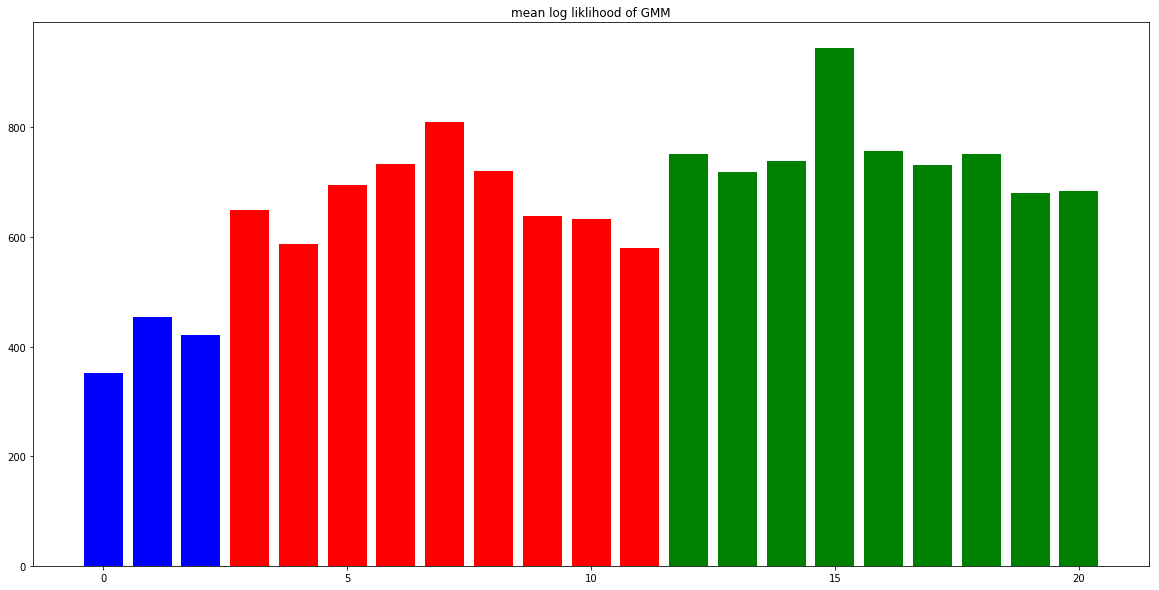

/anaconda3/envs/test_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


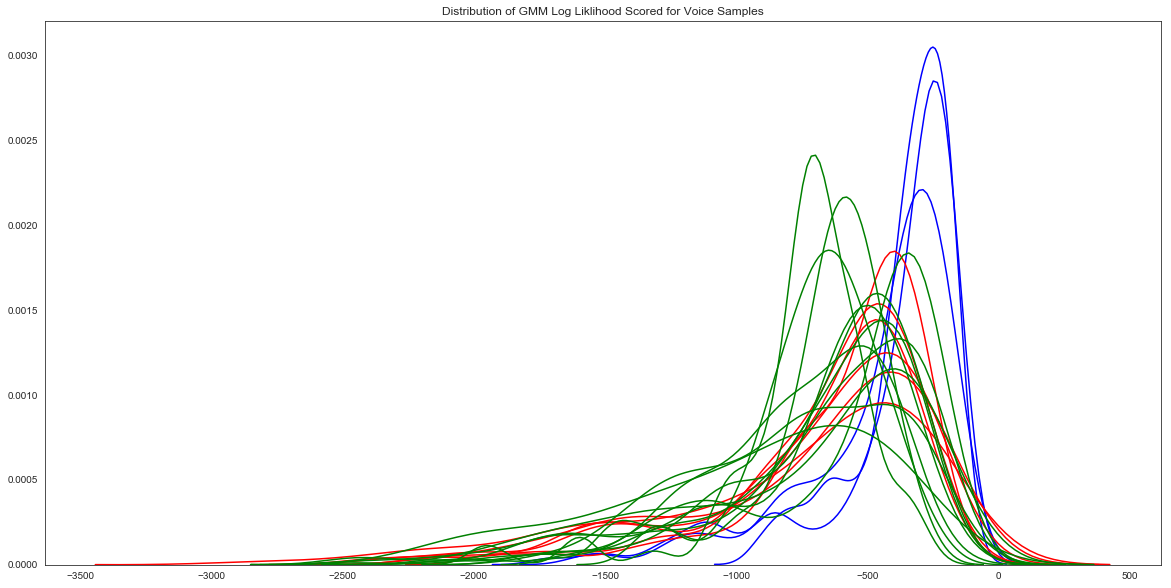

In [37]:
print("Blue = My Voice \nGreen = Other Female Voice \nRed = Other Male Voice")

# mean log liklihoods
mean_log_liklihoods = []
for mfcc in mfcc_list:
    mean_log_liklihoods.append( gmm.score(mfcc) )

plt.figure(figsize=(20,10))
Y = [i for i in -1*np.array(mean_log_liklihoods[1:]) ]
x = [i for i in range(21)]
plt.bar(x,Y,color=['b','b','b','r','r','r','r','r','r','r','r','r','g','g','g','g','g','g','g','g','g'])
plt.title('mean log liklihood of GMM')
plt.show()

# log liklihood distribution
log_liklihoods = []
for mfcc in mfcc_list:
    log_liklihoods.append( gmm.score_samples(mfcc) )

sns.set_style("white")
plt.figure(figsize=(20,10))
for ll in log_liklihoods[1:4]:
    sns.distplot(ll,hist=False,color='b')
for ll in log_liklihoods[4:10]:
    sns.distplot(ll,hist=False,color='r')
for ll in log_liklihoods[10:]:
    sns.distplot(ll,hist=False,color='g')
plt.title("Distribution of GMM Log Liklihood Scored for Voice Samples")
plt.show()

We could try to delve deeper into what exactly our model is learning. There has been some really amazing work to get at the relevant features models like this use to distinguish one voice from another. However, that could be another blog post in itself. Instead, I'll just comment on a couple neat things. For one, it appears that while the model can tell my voice apart from other men, male voice scores are much closer to mine than female voice scores. Additionally, there is significant variance in mean log likelihood across my voice scores. This might indicate that our model doesn't take into account all of the different ways my voice can inflect (to avoid this we might train our model on multiple voice samples). Additionally, our likelihood scores are not symmetric distributions which might mean that we should consider using the median of the distribution instead of the mean in order to compare voice recordings.!

### Parting Words

We've done something really cool here. With a little signal processing and a very naive mixed model we've created a decent voice recognition system. We required very little data, computing power, or time to create this model. Additionally, our approach would be easily scalable to hudnreds of thousands of voices (although we might start to run into problems with voice collisions at scale). Our model also ignores a lot of data like high frequency changes in tone (which we dumped during the MFCC processing step) and speech patterns like pausing (which we lsot when we removed silences), so that we could probably increase our model accuracy if we put more thought into the signal processing. You might also try implementing a HMM instead of a GMM (another common approach to voice recognition before the rise of deep learning).

If you'd like to test some more sophisticated denoising and out-of-the-box voice recognition models, check out this awesome blog post: [The Ultimate Guide To Speech Recognition With Python](https://realpython.com/python-speech-recognition/)

I hope you had fun reading throught this postand will come back for future exercises in the wild, wacky world of data science!